In [108]:
import matplotlib
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
import warnings #to remove the warnings
import random
import sys
sys.path.append('../_hepers_')
from genNewVals import generateNewFeatureValMultiple
from subsampleData import subsample
from models import trainModels
from genFillNulls import *
warnings.filterwarnings('ignore')


In [109]:
def trainF1CrossValModels(X, y, numFolds):
    nb = GaussianNB()
    nbScores = cross_val_score(nb, X, y, cv=numFolds, scoring='f1')
    print('Completed Naive Bayes')
    logisticClassifier = LogisticRegression()
    logScores = cross_val_score(logisticClassifier, X, y, cv=numFolds, scoring='f1')
    print('Completed Logistic Regression')
    svclassifier = SVC(kernel='linear', max_iter = 5000000)
    svmScores = cross_val_score(svclassifier, X, y, cv=numFolds, scoring='f1')
    print('Completed SVM')
    clf = DecisionTreeClassifier(random_state = 42)
    dtScrores = cross_val_score(clf, X, y, cv=numFolds, scoring='f1')
    print('Completed Decision Tree')
    votingCl = VotingClassifier(
                estimators =    [('gnb', GaussianNB()),
                                ('lr',  LogisticRegression()),
                                ('svm', SVC(kernel='linear', max_iter = 5000000)),
                                ('dtc', DecisionTreeClassifier(random_state=42))], 
                voting='hard')
    voteScores = cross_val_score(votingCl, X, y, cv=numFolds, scoring='f1')
    print('Completed Voting Classification')
    return nbScores, logScores, svmScores, dtScrores, voteScores

def generateSupplementalData(X_train, y_train, numBenign = 0, numMalig = 0):
    trainingSet = X_train.copy()
    trainingSet['Diagnosis'] = y_train
    arr2D = trainingSet.to_numpy()
    columnIndex = -1
    sortedArr = arr2D[arr2D[:,columnIndex].argsort()]
    numZeros = list(sortedArr[:, columnIndex]).count(0)
    benignDF, malignantDF = pd.DataFrame(sortedArr[0:numZeros]), pd.DataFrame(sortedArr[numZeros:])
    benignDF.columns, malignantDF.columns = trainingSet.columns, trainingSet.columns
    numBenignNeeded = numBenign - benignDF.shape[0]
    numMaligNeeded = numMalig - malignantDF.shape[0]

    #Storing all Raw Benign Data to Later be Merged with Synthetic
    preExistingBenign = []
    for index, row in benignDF.iterrows():
        preExistingBenign.append(list(row))
    preExistingBenign = np.array(preExistingBenign)
    
    #Storing all Raw Malignant Data to Later be Merged with Synthetic
    preExistingMalig = []
    for index, row in malignantDF.iterrows():
        preExistingMalig.append(list(row))
    preExistingMalig = np.array(preExistingMalig)

    #Generating New Data
    benignPatients = []
    for col in benignDF.columns:
        benignPatients.append(generateNewFeatureValMultiple(benignDF, col, 25, numBenignNeeded))
    benignPatients = np.array(benignPatients).T
    malignangPatients = []
    for col in malignantDF.columns:
        malignangPatients.append(generateNewFeatureValMultiple(malignantDF, col, 25, numMaligNeeded))
    malignangPatients = np.array(malignangPatients).T

    #Combining Real Data and Synthetic Data, or Only using Real Data in the case of majority class
    if np.array(benignPatients).shape[0] > 0:
        benignPatients = np.vstack((preExistingBenign, np.array(benignPatients)))
    else:
        benignPatients = preExistingBenign
    if np.array(malignangPatients).shape[0] > 0:
        malignangPatients = np.vstack((preExistingMalig, np.array(malignangPatients)))
    else:
        benignPatients = preExistingBenign
    jointArray = np.vstack((benignPatients,malignangPatients))
    finalDataset = pd.DataFrame(jointArray, columns = benignDF.columns) 

    #Reporting Summary
    print('Final Dataset Composition: {}'.format(finalDataset.shape))
    print(' - Benign:')
    print('   -   New Benign Instances Created: {}'.format(numBenignNeeded))
    print('   -   Old Benign Instances Used: {}'.format(preExistingBenign.shape[0]))
    print(' - Malignant:')
    print('   -   New Malignant Instances Created: {}'.format(numMaligNeeded))
    print('   -   Old Malignant Instances Used: {}'.format(preExistingMalig.shape[0]))
    return finalDataset

In [110]:
random.seed(42)
np.random.seed(42)
raw_df = pd.read_csv('../../Wisconsin_Database/breast-cancer-wisconsin.data', header=None)
cols = ['ID', 'Thickness', 'SizeUniformity', 'ShapeUniformity', 'Adhesion', 'Size', 'BareNuclei', 'Bland Chromatin', 'Nucleoli', 'Mitoses', 'Diagnosis']
raw_df.columns = cols
raw_df['Diagnosis'] = raw_df['Diagnosis'].map(
                   {2:0,4:1})

temp = []
for index, row in raw_df.iterrows():
    if '?' not in row.values:
        temp.append(row)
        
df = pd.DataFrame(np.array(temp), columns=cols)
df['BareNuclei'] = df['BareNuclei'].astype(np.int)
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.int)


X = df[cols[1:-1]]
y = df[cols[-1]]
subSample = pd.DataFrame(subsample(X, y, 20000, 30))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
numClassSamples = len(y) - sum(y)
finalDataset = generateSupplementalData(X, y, numBenign = numClassSamples, numMalig = numClassSamples)

X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]
augNBWBC, augLogWBC, augSVMWBC, auglDTWBC, augVoteWBC = trainF1CrossValModels(X, y, 10)


print('NB Mean Scores: {}'.format(np.mean(augNBWBC)))
print('LR Mean Scores: {}'.format(np.mean(augLogWBC)))
print('SVM Mean Scores: {}'.format(np.mean(augSVMWBC)))
print('DT Mean Scores: {}'.format(np.mean(auglDTWBC)))
print('VC Mean Scores: {}'.format(np.mean(augVoteWBC)))

(683, 11)
Final Dataset Composition: (888, 10)
 - Benign:
   -   New Benign Instances Created: 0
   -   Old Benign Instances Used: 444
 - Malignant:
   -   New Malignant Instances Created: 414
   -   Old Malignant Instances Used: 30
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.9772022263574929
LR Mean Scores: 0.9834149600098087
SVM Mean Scores: 0.9834149600098087
DT Mean Scores: 0.9607978977544196
VC Mean Scores: 0.9834149600098087


In [111]:
random.seed(42)
np.random.seed(42)
raw_df = pd.read_csv('../../Wisconsin_Database/breast-cancer-wisconsin.data', header=None)
cols = ['ID', 'Thickness', 'SizeUniformity', 'ShapeUniformity', 'Adhesion', 'Size', 'BareNuclei', 'Bland Chromatin', 'Nucleoli', 'Mitoses', 'Diagnosis']
raw_df.columns = cols
raw_df['Diagnosis'] = raw_df['Diagnosis'].map(
                   {2:0,4:1})

temp = []
for index, row in raw_df.iterrows():
    if '?' not in row.values:
        temp.append(row)
        
df = pd.DataFrame(np.array(temp), columns=cols)
df['BareNuclei'] = df['BareNuclei'].astype(np.int)
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.int)


X = df[cols[1:-1]]
y = df[cols[-1]]
subSample = pd.DataFrame(subsample(X, y, 20000, 30))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]

rawNBWBC, rawLogWBC, rawSVMWBC, rawlDTWBC, rawVoteWBC = trainF1CrossValModels(X, y, 10)


print('NB Mean Scores: {}'.format(np.mean(rawNBWBC)))
print('LR Mean Scores: {}'.format(np.mean(rawLogWBC)))
print('SVM Mean Scores: {}'.format(np.mean(rawSVMWBC)))
print('DT Mean Scores: {}'.format(np.mean(rawlDTWBC)))
print('VC Mean Scores: {}'.format(np.mean(rawVoteWBC)))

(683, 11)
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.7335930735930735
LR Mean Scores: 0.7614285714285715
SVM Mean Scores: 0.7257142857142858
DT Mean Scores: 0.8080952380952381
VC Mean Scores: 0.7807142857142858


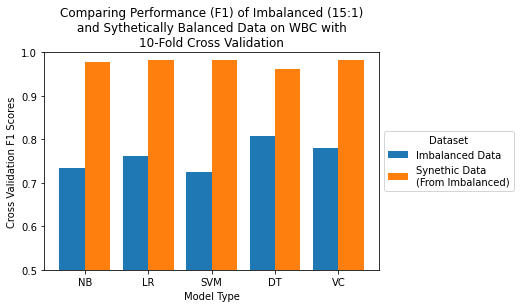

In [123]:
import matplotlib.pyplot as plt 
  
models = ['NB','LR','SVM', 'DT', 'VC' ]


aug = [np.mean(augNBWBC), np.mean(augLogWBC), np.mean(augSVMWBC),
        np.mean(auglDTWBC), np.mean(augVoteWBC)]
reg = [np.mean(rawNBWBC), np.mean(rawLogWBC), np.mean(rawSVMWBC),
        np.mean(rawlDTWBC), np.mean(rawVoteWBC)]
  
X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, reg, 0.4, label = 'Imbalanced Data')
plt.bar(X_axis + 0.2, aug, 0.4, label = 'Synethic Data\n(From Imbalanced)')
  
plt.xticks(X_axis, models)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation F1 Scores")
plt.ylim(0.50,1)
plt.title("Comparing Performance (F1) of Imbalanced (15:1)\n and Sythetically Balanced Data on WBC with \n10-Fold Cross Validation")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [120]:

random.seed(42)
np.random.seed(42)
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.float)

X = df[cols[2:]]
y = df[cols[1]]

subSample = pd.DataFrame(subsample(X, y, 20000, 23))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
numClassSamples = len(y) - sum(y)

finalDataset = generateSupplementalData(X, y,  numBenign = numClassSamples, numMalig = numClassSamples)
X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]

augNBWDBC, augLogWDBC, augSVMWDBC, auglDTWDBC, augVoteWDBC = trainF1CrossValModels(X, y, 10)
print('NB Mean Scores: {}'.format(np.mean(augNBWDBC)))
print('LR Mean Scores: {}'.format(np.mean(augLogWDBC)))
print('SVM Mean Scores: {}'.format(np.mean(augSVMWDBC)))
print('DT Mean Scores: {}'.format(np.mean(auglDTWDBC)))
print('VC Mean Scores: {}'.format(np.mean(augVoteWDBC)))


(569, 32)
Final Dataset Composition: (714, 31)
 - Benign:
   -   New Benign Instances Created: 0
   -   Old Benign Instances Used: 357
 - Malignant:
   -   New Malignant Instances Created: 334
   -   Old Malignant Instances Used: 23
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.9869806859969878
LR Mean Scores: 0.9263634650752071
SVM Mean Scores: 0.9853116388151495
DT Mean Scores: 0.9476661307265205
VC Mean Scores: 0.9867609141774683


In [121]:
random.seed(42)
np.random.seed(42)
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})
print(df.shape)

for i in df:
    df[i] = df[i].astype(np.float)

X = df[cols[2:]]
y = df[cols[1]]

subSample = pd.DataFrame(subsample(X, y, 20000, 23))
X = subSample[subSample.columns[:-1]]
y = subSample[subSample.columns[-1]]
numClassSamples = len(y) - sum(y)

nbWDBC, lrWDBC, svmWDBC, dtWDBC, vcWDBC = trainF1CrossValModels(X, y, 10)
print('NB Mean Scores: {}'.format(np.mean(nbWDBC)))
print('LR Mean Scores: {}'.format(np.mean(lrWDBC)))
print('SVM Mean Scores: {}'.format(np.mean(svmWDBC)))
print('DT Mean Scores: {}'.format(np.mean(dtWDBC)))
print('VC Mean Scores: {}'.format(np.mean(vcWDBC)))



(569, 32)
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.7733333333333333
LR Mean Scores: 0.7866666666666666
SVM Mean Scores: 0.9133333333333333
DT Mean Scores: 0.6752380952380952
VC Mean Scores: 0.8066666666666666


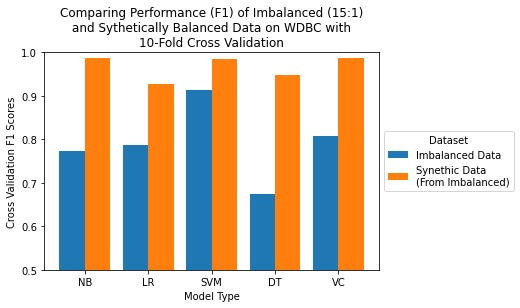

In [124]:
import matplotlib.pyplot as plt 
  
models = ['NB','LR','SVM', 'DT', 'VC' ]


aug = [np.mean(augNBWDBC), np.mean(augLogWDBC),
        np.mean(augSVMWDBC), np.mean(auglDTWDBC), np.mean(augVoteWDBC)]

reg = [np.mean(nbWDBC), np.mean(lrWDBC),
        np.mean(svmWDBC), np.mean(dtWDBC), np.mean(vcWDBC)]
  
X_axis = np.arange(len(models))
  
plt.bar(X_axis - 0.2, reg, 0.4, label = 'Imbalanced Data')
plt.bar(X_axis + 0.2, aug, 0.4, label = 'Synethic Data\n(From Imbalanced)')
  
plt.xticks(X_axis, models)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation F1 Scores")
plt.ylim(0.50,1)
plt.title("Comparing Performance (F1) of Imbalanced (15:1)\n and Sythetically Balanced Data on WDBC with \n10-Fold Cross Validation")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [126]:
random.seed(42)
np.random.seed(42)
cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Diagnosis']
cervical_df.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
for j in cervicalAllNullsSyntheticFilled:
    cervicalAllNullsSyntheticFilled[j] = cervicalAllNullsSyntheticFilled[j].astype(np.float)
X = cervicalAllNullsSyntheticFilled[cervicalCols[:-4]]
y = cervicalAllNullsSyntheticFilled[cervicalCols[-1]]
nullFillNB, nullFillLog, nullFillSVM, nullFillDT, nullFillVote = trainF1CrossValModels(X, y, 10)

print('NB Mean Scores: {}'.format(np.mean(nullFillNB)))
print('LR Mean Scores: {}'.format(np.mean(nullFillLog)))
print('SVM Mean Scores: {}'.format(np.mean(nullFillSVM)))
print('DT Mean Scores: {}'.format(np.mean(nullFillDT)))
print('VC Mean Scores: {}'.format(np.mean(nullFillVote)))


Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.12710098620088256
LR Mean Scores: 0.0
SVM Mean Scores: 0.0
DT Mean Scores: 0.11089444723177393
VC Mean Scores: 0.0


In [128]:
random.seed(42)
np.random.seed(42)
cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Diagnosis']
cervical_df.rename(columns = {'Biopsy':'Diagnosis'}, inplace = True)
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
for j in cervicalAllNullsSyntheticFilled:
    cervicalAllNullsSyntheticFilled[j] = cervicalAllNullsSyntheticFilled[j].astype(np.float)
X = cervicalAllNullsSyntheticFilled[cervicalCols[:-4]]
y = cervicalAllNullsSyntheticFilled[cervicalCols[-1]]
numClassSamples = int(max((len(y) - sum(y)), sum(y)))
finalDataset = generateSupplementalData(X, y, numBenign = numClassSamples, numMalig = numClassSamples)
X = finalDataset[finalDataset.columns[:-1]]
y = finalDataset[finalDataset.columns[-1]]
print(X.shape)

balNullFillNB, balNullFillLog, balNullFillSVM, balNullFillDT, balNullFillVote = trainF1CrossValModels(X, y, 10)

print('NB Mean Scores: {}'.format(np.mean(balNullFillNB)))
print('LR Mean Scores: {}'.format(np.mean(balNullFillLog)))
print('SVM Mean Scores: {}'.format(np.mean(balNullFillSVM)))
print('DT Mean Scores: {}'.format(np.mean(balNullFillDT)))
print('VC Mean Scores: {}'.format(np.mean(balNullFillVote)))

Final Dataset Composition: (1606, 29)
 - Benign:
   -   New Benign Instances Created: 0
   -   Old Benign Instances Used: 803
 - Malignant:
   -   New Malignant Instances Created: 748
   -   Old Malignant Instances Used: 55
(1606, 28)
Completed Naive Bayes
Completed Logistic Regression
Completed SVM
Completed Decision Tree
Completed Voting Classification
NB Mean Scores: 0.6733211227644904
LR Mean Scores: 0.7483148951973388
SVM Mean Scores: 0.7447786311052548
DT Mean Scores: 0.9153688283574841
VC Mean Scores: 0.7910025071365387


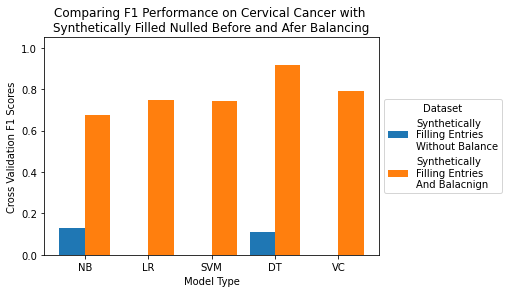

In [131]:
X_Vals = ['NB','LR','SVM', 'DT', 'VC' ]

bal = [np.mean(balNullFillNB), np.mean(balNullFillLog), np.mean(balNullFillSVM),
        np.mean(balNullFillDT), np.mean(balNullFillVote)]
imBal = [np.mean(nullFillNB), np.mean(nullFillLog), np.mean(nullFillSVM),
        np.mean(nullFillDT), np.mean(nullFillVote)]

Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(X_Vals))
  
plt.bar(X_axis - 0.2, imBal, 0.4, label = 'Synthetically\nFilling Entries\nWithout Balance')
plt.bar(X_axis + 0.2, bal, 0.4, label = 'Synthetically\nFilling Entries\nAnd Balacnign')
  
plt.xticks(X_axis, X_Vals)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation F1 Scores")
plt.ylim(0.0,1.05)
plt.title("Comparing F1 Performance on Cervical Cancer with \nSynthetically Filled Nulled Before and Afer Balancing")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
augKnnWDBC = []
augNbWDBC = []
augLrWDBC = []
augSvmWDBC = []
augDtWDBC = []
augVcWDBC = []
print('Data Shape: {}'.format(df.shape))
for i in range(10):
    X = df[cols[2:]]
    y = df[cols[1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    finalDataset = generateSyntheticDataset(X_train, y_train, identical = True)
    X_train = finalDataset[finalDataset.columns[:-1]]
    y_train = finalDataset[finalDataset.columns[-1]]
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    augKnnWDBC.append(scores[0])
    augNbWDBC.append(scores[1])
    augLrWDBC.append(scores[2])
    augSvmWDBC.append(scores[3])
    augDtWDBC.append(scores[4])
    augVcWDBC.append(scores[5])
    print('Iteration: {}'.format(i))


print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(augKnnWDBC), max(augKnnWDBC), sum(augKnnWDBC)/len(augKnnWDBC)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(augNbWDBC), max(augNbWDBC), sum(augNbWDBC)/len(augNbWDBC)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(augLrWDBC), max(augLrWDBC), sum(augLrWDBC)/len(augLrWDBC)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(augSvmWDBC), max(augSvmWDBC), sum(augSvmWDBC)/len(augSvmWDBC)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(augDtWDBC), max(augDtWDBC), sum(augDtWDBC)/len(augDtWDBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(augVcWDBC), max(augVcWDBC), sum(augVcWDBC)/len(augVcWDBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Data Shape: (569, 32)
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.8421052631578947, Max: 0.9298245614035088, Avg: 0.8868421052631579
NB  - Min: 0.9122807017543859, Max: 0.9649122807017544, Avg: 0.9359649122807016
LR  - Min: 0.7982456140350878, Max: 0.8947368421052632, Avg: 0.8421052631578947
SVM - Min: 0.8771929824561403, Max: 0.9473684210526315, Avg: 0.9166666666666666
DT  - Min: 0.9035087719298246, Max: 0.9736842105263158, Avg: 0.9307017543859649
VC  - Min: 0.868421052631579, Max: 0.9649122807017544, Avg: 0.9219298245614036


In [ ]:
knnWDBC = []
nbWDBC = []
lrWDBC = []
svmWDBC = []
dtWDBC = []
vcWDBC = []
for i in range(10):
    X = df[cols[2:]]
    y = df[cols[1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    knnWDBC.append(scores[0])
    nbWDBC.append(scores[1])
    lrWDBC.append(scores[2])
    svmWDBC.append(scores[3])
    dtWDBC.append(scores[4])
    vcWDBC.append(scores[5])
    print('Iteration: {}'.format(i))



print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(knnWDBC), max(knnWDBC), sum(knnWDBC)/len(knnWDBC)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(nbWDBC), max(nbWDBC), sum(nbWDBC)/len(nbWDBC)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(lrWDBC), max(lrWDBC), sum(lrWDBC)/len(lrWDBC)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(svmWDBC), max(svmWDBC), sum(svmWDBC)/len(svmWDBC)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(dtWDBC), max(dtWDBC), sum(dtWDBC)/len(dtWDBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(vcWDBC), max(vcWDBC), sum(vcWDBC)/len(vcWDBC)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.8421052631578947, Max: 0.9473684210526315, Avg: 0.8868421052631579
NB  - Min: 0.9122807017543859, Max: 0.9736842105263158, Avg: 0.9412280701754385
LR  - Min: 0.9035087719298246, Max: 0.9824561403508771, Avg: 0.9508771929824562
SVM - Min: 0.9385964912280702, Max: 0.9824561403508771, Avg: 0.9596491228070174
DT  - Min: 0.9122807017543859, Max: 0.9473684210526315, Avg: 0.9359649122807017
VC  - Min: 0.9210526315789473, Max: 0.9824561403508771, Avg: 0.9526315789473685


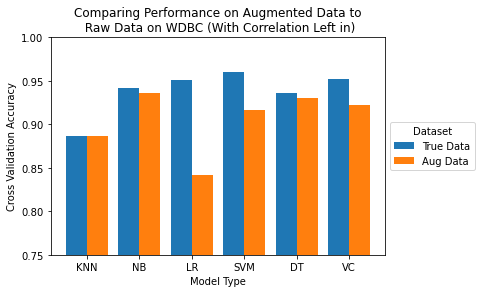

In [ ]:
X = ['KNN','NB','LR','SVM', 'DT', 'VC' ]

aug = [np.mean(augKnnWDBC), np.mean(augNbWDBC), np.mean(augLrWDBC),
        np.mean(augSvmWDBC), np.mean(augDtWDBC), np.mean(augVcWDBC)]
reg = [np.mean(knnWDBC), np.mean(nbWDBC), np.mean(lrWDBC),
        np.mean(svmWDBC), np.mean(dtWDBC), np.mean(vcWDBC)]

Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, reg, 0.4, label = 'True Data')
plt.bar(X_axis + 0.2, aug, 0.4, label = 'Aug Data')
  
plt.xticks(X_axis, X)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(0.75,1)
plt.title("Comparing Performance on Augmented Data to\n Raw Data on WDBC (With Correlation Left in)")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
cols = ['ID', 'Diagnosis', 'radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension',
        'radius_SE', 'texture_SE', 'perimeter_SE', 'area_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
        'radius_MAX', 'texture_MAX', 'perimeter_MAX', 'area_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']
df = pd.read_csv('../../Wisconsin_Database/wdbc.data', header=None)

df.columns = cols
df['Diagnosis'] = df['Diagnosis'].map(
                   {'M':True,'B':False})
#Columns Identified by Correlation Matrix
#When Columns were correlated, that which was most correlated with the target variable (Diagnosis)
#Was Kept
colsInUse = ['ID', 'Diagnosis', 'texture', 'smoothness', 'symmetry', 'fractal_dimension', 
                'radius_SE', 'texture_SE', 'smoothness_SE', 'compactness_SE', 'concavity_SE', 'concave_points_SE', 'symmetry_SE', 'fractal_dimension_SE',
                'texture_MAX', 'perimeter_MAX', 'smoothness_MAX', 'compactness_MAX', 'concavity_MAX', 'concave_points_MAX', 'symmetry_MAX', 'fractal_dimension_MAX']

df = df[colsInUse]



In [ ]:
augKnnWDBC_Stripped = []
augNbWDBC_Stripped = []
augLrWDBC_Stripped = []
augSvmWDBC_Stripped = []
augDtWDBC_Stripped = []
augVcWDBC_Stripped = []
print('Data Shape: {}'.format(df.shape))
for i in range(10):
    X = df[colsInUse[2:]]
    y = df[colsInUse[1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    finalDataset = generateSyntheticDataset(X_train, y_train, identical = True)
    X_train = finalDataset[finalDataset.columns[:-1]]
    y_train = finalDataset[finalDataset.columns[-1]]
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    augKnnWDBC_Stripped.append(scores[0])
    augNbWDBC_Stripped.append(scores[1])
    augLrWDBC_Stripped.append(scores[2])
    augSvmWDBC_Stripped.append(scores[3])
    augDtWDBC_Stripped.append(scores[4])
    augVcWDBC_Stripped.append(scores[5])
    print('Iteration: {}'.format(i))


print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(augKnnWDBC_Stripped), max(augKnnWDBC_Stripped), sum(augKnnWDBC_Stripped)/len(augKnnWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(augNbWDBC_Stripped), max(augNbWDBC_Stripped), sum(augNbWDBC_Stripped)/len(augNbWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(augLrWDBC_Stripped), max(augLrWDBC_Stripped), sum(augLrWDBC_Stripped)/len(augLrWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(augSvmWDBC_Stripped), max(augSvmWDBC_Stripped), sum(augSvmWDBC_Stripped)/len(augSvmWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(augDtWDBC_Stripped), max(augDtWDBC_Stripped), sum(augDtWDBC_Stripped)/len(augDtWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(augVcWDBC_Stripped), max(augVcWDBC_Stripped), sum(augVcWDBC_Stripped)/len(augVcWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Data Shape: (569, 22)
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.8596491228070176, Max: 0.9298245614035088, Avg: 0.9070175438596492
NB  - Min: 0.8947368421052632, Max: 0.9649122807017544, Avg: 0.9219298245614034
LR  - Min: 0.9385964912280702, Max: 0.9736842105263158, Avg: 0.955263157894737
SVM - Min: 0.9473684210526315, Max: 0.9824561403508771, Avg: 0.9561403508771932
DT  - Min: 0.8596491228070176, Max: 0.956140350877193, Avg: 0.9236842105263158
VC  - Min: 0.9298245614035088, Max: 0.9736842105263158, Avg: 0.9552631578947368


In [ ]:
knnWDBC_Stripped = []
nbWDBC_Stripped = []
lrWDBC_Stripped = []
svmWDBC_Stripped = []
dtWDBC_Stripped = []
vcWDBC_Stripped = []
for i in range(10):
    X = df[colsInUse[2:]]
    y = df[colsInUse[1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    knnWDBC_Stripped.append(scores[0])
    nbWDBC_Stripped.append(scores[1])
    lrWDBC_Stripped.append(scores[2])
    svmWDBC_Stripped.append(scores[3])
    dtWDBC_Stripped.append(scores[4])
    vcWDBC_Stripped.append(scores[5])
    print('Iteration: {}'.format(i))



print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(knnWDBC_Stripped), max(knnWDBC_Stripped), sum(knnWDBC_Stripped)/len(knnWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(nbWDBC_Stripped), max(nbWDBC_Stripped), sum(nbWDBC_Stripped)/len(nbWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(lrWDBC_Stripped), max(lrWDBC_Stripped), sum(lrWDBC_Stripped)/len(lrWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(svmWDBC_Stripped), max(svmWDBC_Stripped), sum(svmWDBC_Stripped)/len(svmWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(dtWDBC_Stripped), max(dtWDBC_Stripped), sum(dtWDBC_Stripped)/len(dtWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(vcWDBC_Stripped), max(vcWDBC_Stripped), sum(vcWDBC_Stripped)/len(vcWDBC_Stripped)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.868421052631579, Max: 0.9473684210526315, Avg: 0.9052631578947368
NB  - Min: 0.8947368421052632, Max: 0.956140350877193, Avg: 0.9280701754385964
LR  - Min: 0.9210526315789473, Max: 0.9736842105263158, Avg: 0.9526315789473683
SVM - Min: 0.9210526315789473, Max: 0.9824561403508771, Avg: 0.9587719298245615
DT  - Min: 0.8859649122807017, Max: 0.9649122807017544, Avg: 0.9201754385964913
VC  - Min: 0.9210526315789473, Max: 0.9736842105263158, Avg: 0.9526315789473685


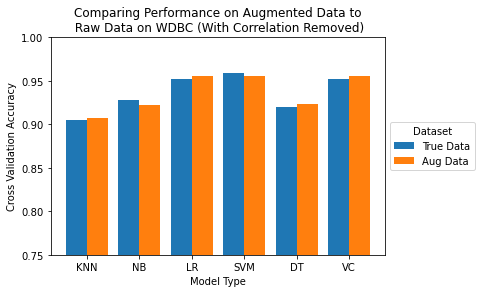

In [ ]:
X = ['KNN','NB','LR','SVM', 'DT', 'VC' ]

aug = [np.mean(augKnnWDBC_Stripped), np.mean(augNbWDBC_Stripped), np.mean(augLrWDBC_Stripped),
        np.mean(augSvmWDBC_Stripped), np.mean(augDtWDBC_Stripped), np.mean(augVcWDBC_Stripped)]
reg = [np.mean(knnWDBC_Stripped), np.mean(nbWDBC_Stripped), np.mean(lrWDBC_Stripped),
        np.mean(svmWDBC_Stripped), np.mean(dtWDBC_Stripped), np.mean(vcWDBC_Stripped)]

Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, reg, 0.4, label = 'True Data')
plt.bar(X_axis + 0.2, aug, 0.4, label = 'Aug Data')
  
plt.xticks(X_axis, X)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(0.75,1)
plt.title("Comparing Performance on Augmented Data to\n Raw Data on WDBC (With Correlation Removed)")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')

cervicalCols = ['Age', 'Number of sexual partners', 'First sexual intercourse',
                'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
                'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
                'IUD (years)', 'STDs (number)', 'STDs:condylomatosis',
                'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
                'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
                'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
                'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
                'Dx:Cancer', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology',
                'Biopsy']

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervical_df = cervical_df[cervicalCols]
cervicalAllNullsRemoved = removeEntriesWithNulls(cervical_df)
print(cervicalAllNullsRemoved.shape)


(59, 32)


In [ ]:
knnCER = []
nbCER = []
lrCER = []
svmCER = []
dtCER = []
vcCER = []
for i in range(10):
    X = cervicalAllNullsRemoved[cervicalCols[:-4]]
    y = cervicalAllNullsRemoved[cervicalCols[-1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    #print('Augmented X Train: {}'.format(X_train.shape))
    #print('Augmented y_train: {}'.format(y_train.shape))
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    knnCER.append(scores[0])
    nbCER.append(scores[1])
    lrCER.append(scores[2])
    svmCER.append(scores[3])
    dtCER.append(scores[4])
    vcCER.append(scores[5])
    print('Iteration: {}'.format(i))


print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(knnCER), max(knnCER), sum(knnCER)/len(knnCER)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(nbCER), max(nbCER), sum(nbCER)/len(nbCER)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(lrCER), max(lrCER), sum(lrCER)/len(lrCER)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(svmCER), max(svmCER), sum(svmCER)/len(svmCER)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(dtCER), max(dtCER), sum(dtCER)/len(dtCER)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(vcCER), max(vcCER), sum(vcCER)/len(vcCER)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.75, Max: 0.9166666666666666, Avg: 0.8666666666666668
NB  - Min: 0.4166666666666667, Max: 0.75, Avg: 0.6000000000000001
LR  - Min: 0.6666666666666666, Max: 0.9166666666666666, Avg: 0.825
SVM - Min: 0.6666666666666666, Max: 0.9166666666666666, Avg: 0.8083333333333333
DT  - Min: 0.6666666666666666, Max: 0.9166666666666666, Avg: 0.7833333333333332
VC  - Min: 0.75, Max: 0.9166666666666666, Avg: 0.8500000000000002


In [ ]:

cervical_df = pd.read_csv('risk_factors_cervical_cancer.csv')
cervical_df = cervical_df[cervicalCols]
cervicalAllNullsSyntheticFilled = genSyntheticFillNulls(cervical_df)
print(cervicalAllNullsSyntheticFilled.shape)

for i in cervicalAllNullsSyntheticFilled:
        cervicalAllNullsSyntheticFilled[i] = cervicalAllNullsSyntheticFilled[i].astype(np.float)

(858, 32)


In [ ]:
augKnnCER = []
augNbCER = []
augLrCER = []
augSvmCER = []
augDtCER = []
augVcCER = []
for i in range(10):
    X = cervicalAllNullsSyntheticFilled[cervicalCols[:-4]]
    y = cervicalAllNullsSyntheticFilled[cervicalCols[-1]]

    SEED = 42 + i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    #print('Augmented X Train: {}'.format(X_train.shape))
    #print('Augmented y_train: {}'.format(y_train.shape))
    scaler = StandardScaler()
    scaler.fit(X_train)

    col_names=df.columns[2:]
    scaled_df = pd.DataFrame(X_train, columns=col_names)
    scaled_df.describe().T
    scores = trainModels(X_train, X_test, y_train, y_test)
    augKnnCER.append(scores[0])
    augNbCER.append(scores[1])
    augLrCER.append(scores[2])
    augSvmCER.append(scores[3])
    augDtCER.append(scores[4])
    augVcCER.append(scores[5])
    print('Iteration: {}'.format(i))


print('KNN - Min: {}, Max: {}, Avg: {}'.format(min(augKnnCER), max(augKnnCER), sum(augKnnCER)/len(augKnnCER)))
#print('   Best Seed: {}'.format(42 + knnScores.index(max(knnScores))))
print('NB  - Min: {}, Max: {}, Avg: {}'.format(min(augNbCER), max(augNbCER), sum(augNbCER)/len(augNbCER)))
#print('   Best Seed: {}'.format(42 + naiveBaysScores.index(max(naiveBaysScores))))
print('LR  - Min: {}, Max: {}, Avg: {}'.format(min(augLrCER), max(augLrCER), sum(augLrCER)/len(augLrCER)))
#print('   Best Seed: {}'.format(42 + logisticRegressionScores.index(max(logisticRegressionScores))))
print('SVM - Min: {}, Max: {}, Avg: {}'.format(min(augSvmCER), max(augSvmCER), sum(augSvmCER)/len(augSvmCER)))
#print('   Best Seed: {}'.format(42 + svmRegressionScores.index(max(svmRegressionScores))))
print('DT  - Min: {}, Max: {}, Avg: {}'.format(min(augDtCER), max(augDtCER), sum(augDtCER)/len(augDtCER)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))
print('VC  - Min: {}, Max: {}, Avg: {}'.format(min(augVcCER), max(augVcCER), sum(augVcCER)/len(augVcCER)))
#print('   Best Seed: {}'.format(42 + decisionTreeRegressionScores.index(max(decisionTreeRegressionScores))))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
KNN - Min: 0.9244186046511628, Max: 0.9709302325581395, Avg: 0.9459302325581396
NB  - Min: 0.1511627906976744, Max: 0.2616279069767442, Avg: 0.21744186046511627
LR  - Min: 0.9244186046511628, Max: 0.9651162790697675, Avg: 0.944186046511628
SVM - Min: 0.9244186046511628, Max: 0.9709302325581395, Avg: 0.9459302325581396
DT  - Min: 0.8604651162790697, Max: 0.9244186046511628, Avg: 0.8895348837209301
VC  - Min: 0.9244186046511628, Max: 0.9709302325581395, Avg: 0.944767441860465


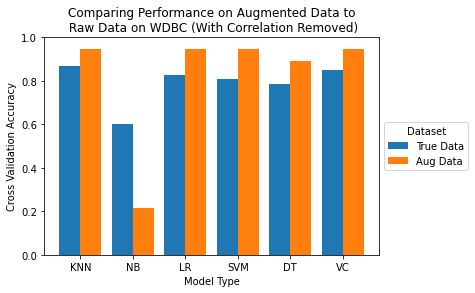

In [ ]:
X = ['KNN','NB','LR','SVM', 'DT', 'VC' ]

aug = [np.mean(augKnnCER), np.mean(augNbCER), np.mean(augLrCER),
        np.mean(augSvmCER), np.mean(augDtCER), np.mean(augVcCER)]
reg = [np.mean(knnCER), np.mean(nbCER), np.mean(lrCER),
        np.mean(svmCER), np.mean(dtCER), np.mean(vcCER)]

Ygirls = [10,20,20,40]
Zboys = [20,30,25,30]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, reg, 0.4, label = 'True Data')
plt.bar(X_axis + 0.2, aug, 0.4, label = 'Aug Data')
  
plt.xticks(X_axis, X)
plt.xlabel("Model Type")
plt.ylabel("Cross Validation Accuracy")
plt.ylim(0,1)
plt.title("Comparing Performance on Augmented Data to\n Raw Data on WDBC (With Correlation Removed)")
plt.legend(title='Dataset',loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()